# Imports

In [1]:
import os
import pickle
import random
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from pathlib import Path

from pfc_packages.pointNet import *
from pfc_packages.utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Hyperparameters

In [20]:
NUM_CLASSES = 20
INPUT_CHANNELS = 9
EPOCHS = 150
LR = 0.001
DECAY_RATE = 0 # 0.0001
MOMENTUM_DECCAY_STEP = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "checkpoints_to_ignore/models/model"
SEQ_LIST = [5]
SEQ_LIST_NAME = "".join(str(s) for s in SEQ_LIST)

# Model configs

In [3]:
# ==== MODEL ====
model = PointNetSeg(num_classes=NUM_CLASSES, input_channels=INPUT_CHANNELS).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=DECAY_RATE
)

In [4]:
"""
desativar todas as regularizações
tentar aumentar o maximo possivel o tamanho do dataset
aumentar o modelo se nescessario
ideia do padding se nescessaria la pra frente
aumentar os features, desvio padrado de cada coordenada, bean numpy histograma
tentar manter o valor da acuracia em 90%
"""

'\ndesativar todas as regularizações\ntentar aumentar o maximo possivel o tamanho do dataset\naumentar o modelo se nescessario\nideia do padding se nescessaria la pra frente\naumentar os features, desvio padrado de cada coordenada, bean numpy histograma\ntentar manter o valor da acuracia em 90%\n'

# Pre-process clusters

In [38]:
## ==== LOAD DATA ====
# unprocessed_train_dataset = SemanticKittiDataset(
#     "../../datasets/semantic-kitti", load_cluster=True, sequence_list=SEQ_LIST
# )

# processed_train_dataset = []

# for frame in tqdm(unprocessed_train_dataset, desc="Processando frames"):
#     processed_train_dataset.append(
#         extract_features_from_clusters(frame, min_cluster_size=3)
#     )

# with open(f"./checkpoints_to_ignore/processed_train_dataset/seq{SEQ_LIST_NAME}.pkl", "wb") as f:
#     pickle.dump(processed_train_dataset, f)

SEQ_LIST = [5]
SEQ_LIST_NAME = "".join(str(s) for s in SEQ_LIST)

with open(
    f"./checkpoints_to_ignore/processed_train_dataset/seq{SEQ_LIST_NAME}.pkl", "rb"
) as f:
    p = pickle.load(f)

processed_train_dataset.extend(p)
print(len(processed_train_dataset))

23201


In [40]:
max_clusters = max(f.shape[0] for f in processed_train_dataset)
print(max_clusters, len(processed_train_dataset))
print(processed_train_dataset[0][0])

2112 23201
[72.97862244  2.4499929   2.67745876 72.97862244  2.4499929   2.67745876
 72.97862244  2.4499929   2.67745876  9.          0.        ]


# Train model

In [7]:
loss_history = []
acc_history = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_points = 0
    frame_acc = 0.0

    random.shuffle(processed_train_dataset)
    for item in tqdm(
        processed_train_dataset,
        desc=f"Epoch {epoch}/{EPOCHS}",
        unit="frame",
        leave=False,
    ):
        data = (
            torch.tensor(item[:, :INPUT_CHANNELS], dtype=torch.float32)
            .unsqueeze(0)
            .to(DEVICE)
        )
        label = torch.tensor(item[:, -2], dtype=torch.long).unsqueeze(0).to(DEVICE)

        optimizer.zero_grad()
        pred, trans_feat = model(data)
        pred = pred.view(-1, NUM_CLASSES)
        label = label.view(-1)

        loss = criterion(pred, label)
        # Exemplo de como seria se estivesse ativa (NÃO FAÇA ISSO PARA OVERFIT):
        # if trans_feat is not None and model.feat.feature_transform: # trans_feat é a segunda saída do modelo
        #    reg_loss = feature_transform_regulaizer(trans_feat)
        #    loss = loss + 0.001 * reg_loss # 0.001 é um exemplo de peso da regularização
        pred = pred.argmax(dim=1)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (pred.cpu().numpy() == label.cpu().numpy()).sum()
        total_points += len(label)

    avg_loss = total_loss / len(processed_train_dataset)
    frame_acc = total_correct / total_points
    avg_acc = frame_acc / len(processed_train_dataset)
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)

    if epoch % 10 == 0:
        print(f"[Epoch {epoch:05d}] Loss: {avg_loss:.4f} | Acc: {frame_acc*100:.2f}%")

        # --- Bloco de avaliação ---
        model.eval()
        total_correct = 0
        total_points = 0
        with torch.no_grad():
            for item in tqdm(
                processed_train_dataset,
                desc=f"Eval @ Epoch {epoch}/{EPOCHS}",
                unit="frame",
                leave=False,
            ):
                # for item in processed_train_dataset:
                data = (
                    torch.tensor(item[:, :INPUT_CHANNELS], dtype=torch.float32)
                    .unsqueeze(0)
                    .to(DEVICE)
                )
                label = item[:, -2]

                pred, trans_feat = model(data)

                pred = pred.view(-1, NUM_CLASSES)
                pred = pred.argmax(dim=1)

                total_correct += (pred.cpu().numpy() == label).sum()
                total_points += len(label)
        eval_acc = total_correct / total_points
        print(f"[Eval @ Epoch {epoch:05d}] Acurácia global: {eval_acc*100:.2f}%")

# Opcional: salvar checkpoints
model_name_saved = f"{MODEL_SAVE_PATH}_e{EPOCHS:03d}_s{SEQ_LIST_NAME}_ic{INPUT_CHANNELS}"
torch.save(model.state_dict(), f"{model_name_saved}.pth")

[Epoch 00000] Loss: 1.1967 | Acc: 60.87%


[Eval @ Epoch 00000] Acurácia global: 65.37%


[Epoch 00010] Loss: 0.5985 | Acc: 81.31%


[Eval @ Epoch 00010] Acurácia global: 81.39%


[Epoch 00020] Loss: 0.4751 | Acc: 85.36%


[Eval @ Epoch 00020] Acurácia global: 85.84%


[Epoch 00030] Loss: 0.4030 | Acc: 87.58%


[Eval @ Epoch 00030] Acurácia global: 87.27%


[Epoch 00040] Loss: 0.3531 | Acc: 89.07%


[Eval @ Epoch 00040] Acurácia global: 89.35%


[Epoch 00050] Loss: 0.3158 | Acc: 90.18%


[Eval @ Epoch 00050] Acurácia global: 90.36%


[Epoch 00060] Loss: 0.2873 | Acc: 91.04%


[Eval @ Epoch 00060] Acurácia global: 91.36%


[Epoch 00070] Loss: 0.2650 | Acc: 91.67%


[Eval @ Epoch 00070] Acurácia global: 92.09%


[Epoch 00080] Loss: 0.2461 | Acc: 92.25%


[Eval @ Epoch 00080] Acurácia global: 92.46%


[Epoch 00090] Loss: 0.2306 | Acc: 92.70%


[Eval @ Epoch 00090] Acurácia global: 92.94%


[Epoch 00100] Loss: 0.2176 | Acc: 93.07%


[Eval @ Epoch 00100] Acurácia global: 92.97%


[Epoch 00110] Loss: 0.2064 | Acc: 93.41%


[Eval @ Epoch 00110] Acurácia global: 93.31%


[Epoch 00120] Loss: 0.1963 | Acc: 93.71%


[Eval @ Epoch 00120] Acurácia global: 93.97%


[Epoch 00130] Loss: 0.1875 | Acc: 93.97%


[Eval @ Epoch 00130] Acurácia global: 94.20%


[Epoch 00140] Loss: 0.1795 | Acc: 94.21%


[Eval @ Epoch 00140] Acurácia global: 94.34%


In [8]:
# from torch.utils.data import DataLoader, TensorDataset

# # Supondo que processed_train_dataset seja uma lista de arrays (N, C)
# # Concatene todos os frames em um único array
# all_data = np.concatenate([item[:, :INPUT_CHANNELS] for item in processed_train_dataset], axis=0)
# all_labels = np.concatenate([item[:, -2] for item in processed_train_dataset], axis=0)

# dataset = TensorDataset(
#     torch.tensor(all_data, dtype=torch.float32),
#     torch.tensor(all_labels, dtype=torch.long)
# )
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# for epoch in range(EPOCHS):
#     for data, label in loader:
#         # data: (B, INPUT_CHANNELS)
#         # label: (B,)
#         # ... seu código ...

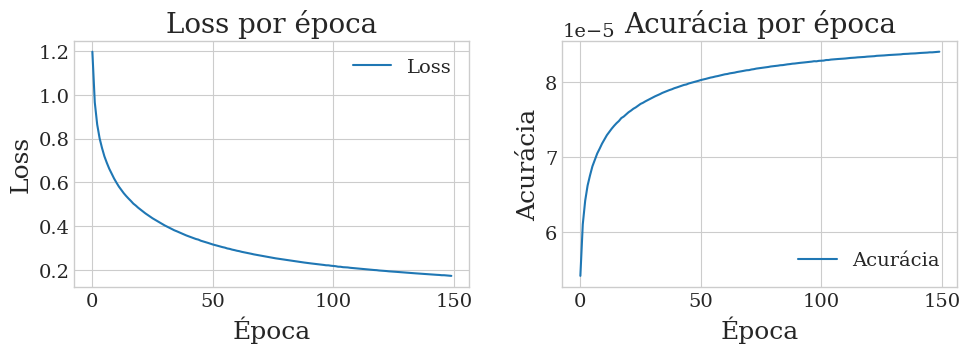

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Loss por época")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label="Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Acurácia por época")
plt.grid(True)
plt.legend()

plt.tight_layout()

# Salve ANTES do plt.show()
plot_dir = Path("plots/loss_acc")
plot_dir.mkdir(parents=True, exist_ok=True)
plot_filename_base = Path(model_name_saved).name
plt.savefig(plot_dir/f"{plot_filename_base}.png", dpi=300, bbox_inches="tight")

plt.show()

# Inference

In [11]:
total_correct = 0
total_points = 0

model.eval()
with torch.no_grad():
    for point_cloud in tqdm(processed_train_dataset, desc="Inferência"):
        data = (
            torch.tensor(point_cloud[:, :INPUT_CHANNELS], dtype=torch.float32)
            .unsqueeze(0)
            .to(DEVICE)
        )
        label = point_cloud[:, -2]
        pred, trans = model(data)
        pred = pred.view(-1, NUM_CLASSES)
        pred = pred.argmax(dim=1).cpu().numpy()

        total_correct += (label == pred).sum()
        total_points += len(label)

mean_accuracy = total_correct / total_points
print(f"Acurácia global em todos os pontos: {mean_accuracy*100:.2f}%")

Inferência: 100%|██████████| 11238/11238 [00:22<00:00, 503.60it/s]

Acurácia global em todos os pontos: 94.61%


In [12]:
point_cloud = processed_train_dataset[4000]

data = (
    torch.tensor(point_cloud[:, :INPUT_CHANNELS], dtype=torch.float32)
    .unsqueeze(0)
    .to(DEVICE)
)
label = point_cloud[:, -2]

# # Carregar o modelo treinado
# model = PointNetSeg(num_classes=NUM_CLASSES).to(DEVICE)
# model.load_state_dict(torch.load("checkpoints/pointnet_epoch_001.pth"))

model.eval()
with torch.no_grad():
    pred, trans = model(data)
    pred = pred.view(-1, NUM_CLASSES)

    # pred_labels = torch.argmax(pred, dim=1).cpu().numpy()
    pred = pred.argmax(dim=1)

# Agora, substituindo os rótulos originais pelos rótulos preditos
# Mantendo as coordenadas xyz no formato original e substituindo o label
result = np.hstack(
    (
        data.squeeze(0).cpu().numpy(),
        label.reshape(-1, 1),
        pred.cpu().numpy().reshape(-1, 1),
    )
)

In [13]:
# Calcula a acurácia usando o array result
true_labels = result[:, -2]
pred_labels = result[:, -1]
accuracy = (true_labels == pred_labels).sum() / len(result)
print(f"Acurácia (amostra): {accuracy*100:.2f}%")
# print(f"[Epoch {epoch:05d}] Loss: {avg_loss:.4f} | Acc: {avg_acc*100:.2f}%")
run_viz(
    result,
    cluster_viz=True,
    show_pred_label=True,
    point_size=3,
    # show_min_max=True,
)
run_viz(
    result,
    cluster_viz=True,
    show_true_label=True,
    point_size=3,
    # show_min_max=True,
)

Acurácia (amostra): 90.78%
